# Avaliação 03 Processamento de Imagens
Discente: Francisco Almir dos Santos Junior

Turmas: Processamento de Imagens 2025.2

Projeto da Avaliação 03

Referência: https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e

## Objetivos Gerais do Projeto
- Levando em consideração que o projeto original baseia-se na detecção de placas através de técnicas de visão computacional, o mesmo não poderá ser reproduzido nesse projeto visto que há temas que não foram abordados em sala de aula, então o escopo do projeto a ser desenvolvido nesse notebook destina-se a uma implementação bem mais simples e rigorosa com os conteúdos abordados em sala de aula.

- O projeto a ser desenvolvido, sobre a base de imagens mencionada acima, que apresenta um conjunto de imagens de carros, tem como objetivo o destaque das regiões da imagem que representam as placas dos carros.

- A princípio, tenho como objetivo explorar as técnicas de filtro para melhorar a visibilidade da imagem e realçar áreas de interesse, utilizar técnicas de thresholding para tornar a imagem binária e por fim utilizar técnicas de segmentação de imagens como as transformadas de hough para identificar as retas na imagem, o que acredito que irá facilitar a detecção de formas de interesse na imagem, o que nesse caso são as placas dos veículos, além disso também tenho como objetivo tentar implementar as transformações geométricas para tentar deixar sempre a imagem o mais horizontal possível.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# import libraries and functions used for convolution and spatial filters application
from scipy.signal import convolve2d

# import libraries and functions from skimg.morphology
from skimage.morphology import square, dilation, erosion, binary_dilation, binary_erosion, footprint_rectangle, opening, closing

from skimage import color
from skimage.io import imread
from skimage.filters import sobel, sobel_v, sobel_h, gaussian
from skimage.measure import label, regionprops

# import libraries and functions from skimage.transformation
from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.draw import rectangle_perimeter


import matplotlib.patches as mpatches

### Passo 1 - Aquisição e visualização dos dados

---



- Inicialmente iremos utilizar a funcionalidade de input/output da ferramenta skimage. Nesse ponto é importante destacar que a imagem que será processada deve estar em escala de nível de cinza, visto que as técnicas abordadas em sala de aula focaram em descrever as transformações e processos a partir de uma imagem unidimensional para descrição da luminosidade do pixel.

- Após carregar a imagem, o próximo passo é visualizar o contexto geral através do histograma, para conseguirmos visualizar quais as características da imagem. De modo geral, as imagens presentes no dataset do problema original do dataflow são imagens claras, com pouco ou quase nenhum ruído.

- A partir desse ponto, nosso objetivo é destacar as informações de interesse na imagem, no caso, suavizar ruídos na imagem, destacar as linhas que representam a placa, que se trata de uma região de alta frequência na vertical, ou seja, há muitas transições preto-branco por conta dos caracteres da placa.

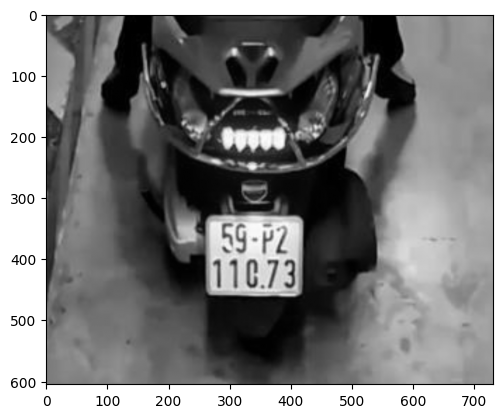

In [ ]:
img = (io.imread('img/mt_01.png', as_gray=True)*255).astype('uint8')
plt.imshow(img, cmap='gray')

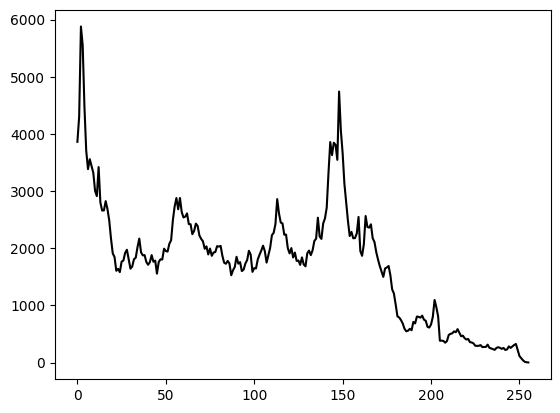

In [61]:
h,_ = np.histogram(img, bins=256)
plt.plot(h, '-k')

### Passo 2 - Pré-processamento e Realce de bordas

---



- Definição de borda e região homogênea.
- Para podermos identificar qual região representa a placa do carro, precisamos fazer uma "limpeza" na imagem para eliminar informações desnecessárias sobre o fundo e marcações do carro. Para isso iremos utilizar técnicas específicas para detecção de bordas, nesse caso o filtro de sobel, porque ele é robusto a ruídos. A principal vantagem de sobel é que ele suaviza a textura granulada do asfalto/carro enquanto destaca as estrutura da placa.

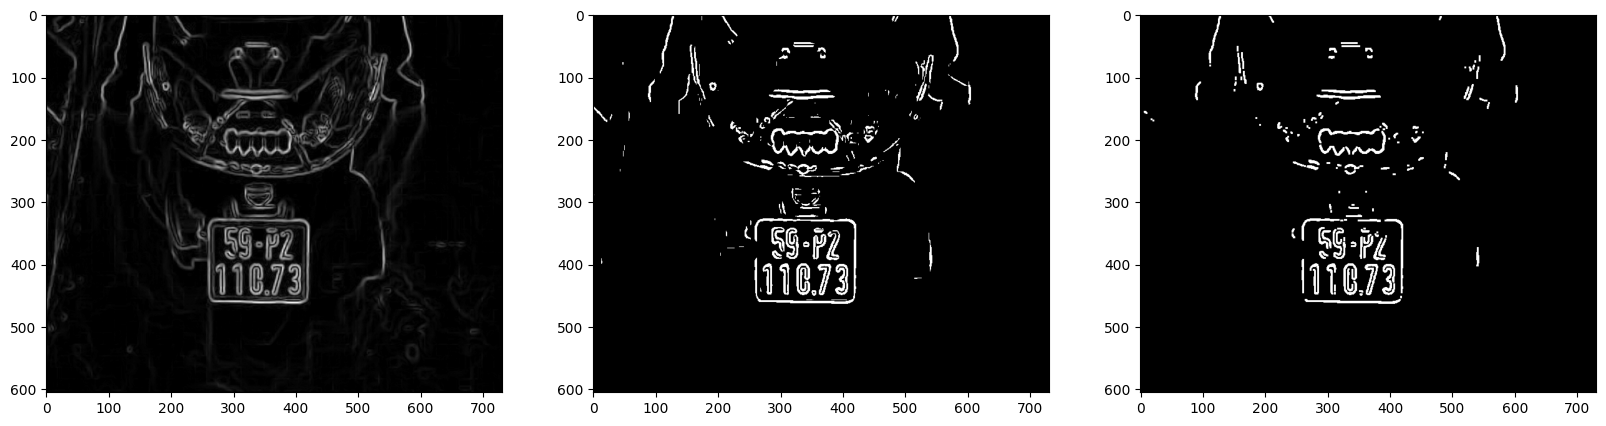

In [62]:
sobel_img = (sobel(img) * 255).astype('uint8')

limiar = sobel_img.max() * 0.35
binary_img = sobel_img > limiar

ee = footprint_rectangle((3,3))
edges = (opening(binary_img,ee)*255).astype('uint8')

_,ax = plt.subplots(1,3,figsize=(20,14))
ax[0].imshow(sobel_img, cmap='gray')
ax[1].imshow(binary_img, cmap='gray')
ax[2].imshow(edges, cmap='gray')

### Passo 3 - Transformada de Hough para Identificar Retas

---
- Nesta sessão iremos utilizar a transformada de hough para identificar as candidatas a retas na imagem, que após o tratamento com sobel e os fechamentos morfológicos teve a quantidade de ruído na imagem reduzido drasticamente.


In [63]:
tested_angles = np.linspace(-np.pi/2, np.pi/2, 180, endpoint=False)
h, theta, d = hough_line(edges, theta=tested_angles)

[Text(0, 0, '-949.0'),
 Text(0, 474, '-474.5'),
 Text(0, 948, '0.0'),
 Text(0, 1422, '474.5'),
 Text(0, 1896, '949.0')]

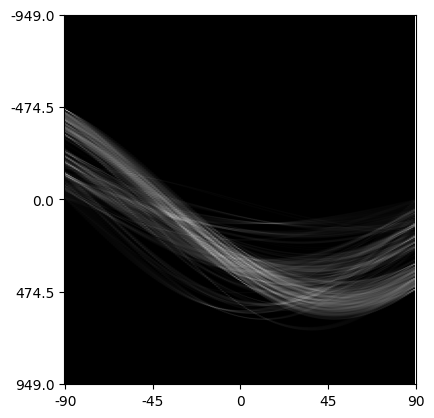

In [64]:
fig, ax = plt.subplots()
ax.imshow(h, cmap='gray',aspect=1/10)
ax.set_xticks(range(0,181,45))
ax.set_xticklabels(['-90','-45', '0', '45', '90'])
ax.set_yticks(range(0,len(d)+1,int(len(d)/4)))
ax.set_yticklabels([str (np.round(x,1)) for x in np.linspace(d.min(), d.max(), 5, endpoint=True)])

[Text(0, 0, '-949.0'),
 Text(0, 474, '-474.5'),
 Text(0, 948, '0.0'),
 Text(0, 1422, '474.5'),
 Text(0, 1896, '949.0')]

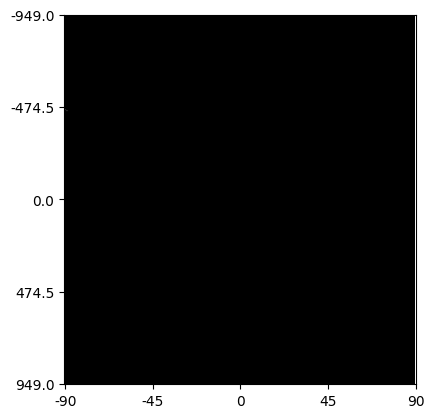

In [65]:
h_aux = h.copy()
h_aux[h_aux<150] = 0
fig, ax = plt.subplots()
ax.imshow (h_aux,cmap='gray',aspect=1/10)
ax.set_xticks(range(0,181,45))
ax.set_xticklabels(['-90','-45','0','45','90'])
ax.set_yticks(range(0,len(d)+1,int(len(d)/4)))
ax.set_yticklabels([str (np.round(x,1)) for x in np.linspace(d.min(),d.max(),5,endpoint=True)])

In [66]:
h_aux.min()

np.uint64(0)

In [ ]:
from skimage import color
from skimage.draw import line

lines = list()
for i in range (h_aux.shape[0]):
    for j in range (h_aux.shape[1]):
        if h_aux[i,j]:
            lines.append ((d[i],theta[j]))

angulos = list()
image_color = color.gray2rgb(edges)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0]
        ang = lines[i][1]
        deg = np.rad2deg (ang)
        angulos.append(ang)
        a = np.cos(ang)
        b = np.sin(ang)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        linha = line (pt1[0],pt1[1],pt2[0],pt2[1])
        for pt in zip (linha[1], linha[0]):
            if 1 <= pt[0] < edges.shape[0]-1 and 0 <= pt[1] < edges.shape[1]:
                image_color[pt[0], pt[1]] = (0, 0, 255)
                #print(f"image_color[{pt[0]}, {pt[1]}] = {image_color[pt[0], pt[1]]}")
                image_color[pt[0]-1, pt[1]] = (0, 0, 255)
                image_color[pt[0]+1, pt[1]] = (0, 0, 255)



In [68]:
lines

[(np.float64(-460.0), np.float64(-1.5707963267948966)),
 (np.float64(-453.0), np.float64(-1.5533430342749532))]

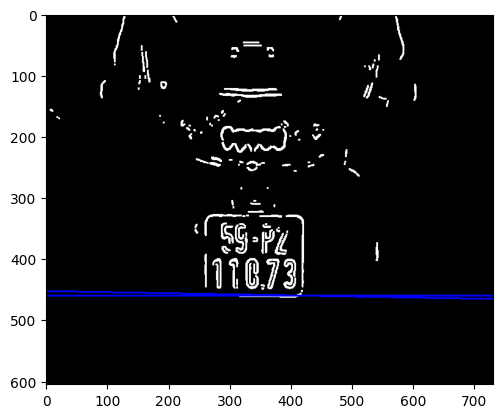

In [69]:
plt.imshow(image_color)

### Passo 4: Rotação da imagem e recorte da região da placa

---
- Neste ponto, já temos a angulaçao das retas encontradas na imagem, iremos utilizar essas angulações para realizar a rotação da imagem.
- A mediana foi adotada nesse caso para lidar com a ocorrência de diversas retas sobrepostas em uma única região, após obter a mediana é realizada uma verificação do grau do ângulo obtido, visto que a orientação pode variar de 0 a 90.


In [70]:
[np.rad2deg(x) for x in angulos]

[np.float64(-90.0), np.float64(-89.0)]

In [71]:
median_ang = np.median([np.rad2deg(x) for x in angulos])
median_ang

np.float64(-89.5)

In [72]:
if median_ang <= -45:
  final_angle = 90 + median_ang
elif median_ang >= 45:
  final_angle = median_ang - 90
else:
  final_angle = median_ang

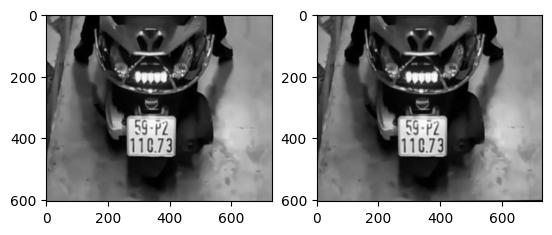

In [73]:
img_rotated = rotate (img,final_angle)
_,ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img_rotated, cmap='gray')

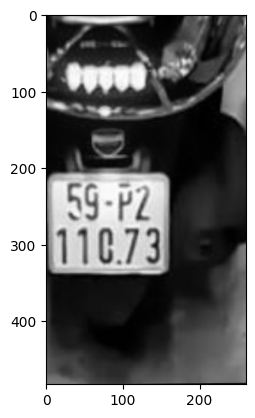

In [74]:
rows, cols = edges.shape
contagem_linhas = []
contagem_colunas = []

for i in range(rows):
    pixels_brancos = 0
    for j in range(cols):
        if edges[i, j] > 0:
            pixels_brancos += 1
    contagem_linhas.append(pixels_brancos)

for j in range(cols):
    pixels_brancos = 0
    for i in range(rows):
        if edges[i, j] > 0:
            pixels_brancos += 1
    contagem_colunas.append(pixels_brancos)


max_linha = max(contagem_linhas)
max_coluna = max(contagem_colunas)

y_inicio, y_fim = 0, rows
x_inicio, x_fim = 0, cols

for i, valor in enumerate(contagem_linhas):
    if valor > max_linha * 0.5:
        y_inicio = i
        break
for i in range(rows-1, -1, -1):
    if contagem_linhas[i] > max_linha * 0.5:
        y_fim = i
        break

for j, valor in enumerate(contagem_colunas):
    if valor > max_coluna * 0.5:
        x_inicio = j
        break
for j in range(cols-1, -1, -1):
    if contagem_colunas[j] > max_coluna * 0.5:
        x_fim = j
        break

placa_final = img_rotated[y_inicio:y_fim + 300, x_inicio:x_fim + 100]
plt.imshow(placa_final, cmap='gray')

### Conclusão do Projeto

---
- A implementaçao do projeto demonstrou que é possível definir, a partir das técnicas de filtragem de imagem, operadores morfológicos e transformadas de hough, a localização de objetos complexos (placas dos veículos) sem a utilizaçao de bibliotecas de visão computacional de alto níve, apesar das limitações impostas pelas técnicas mencionadas acima, é possível dizer que o projeto desenvolvido tem uma eficácia ao que se propõe a fazer.

O projeto baseou-se em um pipeline linear de processamento:

1. Realce de bordas e filtragem: Uso dos operadores de Sobel permitiu o destacamento de regiões de alta frequência (bordas).

2. Morfologia Matemática: Aplicação do operador de fechamento permitiu eliminar informações desnecessárias e "agrupar" os pixels do objeto de interesse em um bloco mais denso.

3. Análise no domínio de Hough: Utilização das transformadas permitiu detectar a presença de retas na imagem, útil principalmente para definir qual a angulação de correção da imagem.

4. Heurística para recorte de imagem: A implementação manual de contadores de densidade mostrou-se uma alterantiva eficaz para o problema, apesar de ter um custo computacional considerável, que pode ser ajustado no futuro para ganhos de performance. A estratégia mostrou útil para identificar intervalos de maior acúmulo de pixels, o algoritmo foi capaz de realizar o corte adequado da imagem, ou ainda, obter a subimagem que contém a placa.

Por fim, como mencionado na introdução este projeto não é tão potente quanto um projeto que faça utilização de ferramentas mais modernas de visão computacional, porém serve para demonstração que é possível realizar a detecção de objetos complexos específicos na imagem a partir da utilização de ferramentas mais elementares como morfologia matemática e filtros espaciais.